<a href="https://colab.research.google.com/github/GeorgeSieW/Supervised-Learning-Final-Project/blob/main/Supervised_Learning_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#My Supervised Learning Final Project

**Data source and provenance:** I am using the “Estimation of Obesity Levels Based on Eating Habits and Physical Condition” dataset from the UCI Machine Learning Repository (loaded via ucimlrepo, dataset id 544). The data come from a self-reported survey on eating habits and physical activity. Respondents provided demographics and lifestyle information. The dataset contains 2,111 individuals with 16 input variables and a multi-class target NObeyesdad that labels the person’s obesity level. UCI hosts the dataset for research and educational use and it is widely used for classification/ordinal-classification studies. In this project, I cite UCI as the data source and keep the original feature names and target definition.

**Problem statement:** Predict an individual’s obesity level as an ordered outcome from survey features on diet and physical activity, and then compute the smallest actionable change, for example, one-step increases in water intake, activity, or meal patterns that would reduce the predicted level by one step. The goal is to deliver accurate classification and practical, low-cost lifestyle prescriptions.

**Supervised Machine Learning Approach:** Ordinal Logistic Regression Model will compare against Gradient Boosted Trees

In [134]:
# pip install ucimlrepo pandas scikit-learn

In [135]:
# Setup and load dataset
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from ucimlrepo import fetch_ucirepo
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import f1_score, balanced_accuracy_score

# fetch by UCI id
obesity = fetch_ucirepo(id=544)

# features and target as DataFrames
X = obesity.data.features.copy()
y = obesity.data.targets.copy()

# target column
target_col = y.columns[0]           # robust in case name changes
df = pd.concat([X, y.rename(columns={target_col: "obesity_level"})], axis=1)


## Exploratory Data Analysis — Inspect, Visualize and Clean the Data

In [136]:
# Quick structure, types, and basic checks
print(df.shape)
df.info()
df.head()

# how many unique values per column (helps spot weird encodings)
nun = df.nunique().sort_values(ascending=False)
nun.to_frame("nunique").head(20)

(2111, 17)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2111 entries, 0 to 2110
Data columns (total 17 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   Gender                          2111 non-null   object 
 1   Age                             2111 non-null   float64
 2   Height                          2111 non-null   float64
 3   Weight                          2111 non-null   float64
 4   family_history_with_overweight  2111 non-null   object 
 5   FAVC                            2111 non-null   object 
 6   FCVC                            2111 non-null   float64
 7   NCP                             2111 non-null   float64
 8   CAEC                            2111 non-null   object 
 9   SMOKE                           2111 non-null   object 
 10  CH2O                            2111 non-null   float64
 11  SCC                             2111 non-null   object 
 12  FAF                    

,nunique
Height,1574
Weight,1525
Age,1402
CH2O,1268
FAF,1190
TUE,1129
FCVC,810
NCP,635
obesity_level,7
MTRANS,5


In [137]:
# Missing values, duplicates, and constant columns

# missingness summary
na = df.isna().mean().sort_values(ascending=False)
display((na*100).round(2).to_frame("% missing").head(20))

# duplicates
dup_count = df.duplicated().sum()
print("Duplicate rows:", dup_count)
if dup_count:
    df = df.drop_duplicates().reset_index(drop=True)

# constant / near-constant columns
const_cols = [c for c in df.columns if df[c].nunique() <= 1]
print("Constant cols:", const_cols)

,% missing
Gender,0.0
Age,0.0
Height,0.0
Weight,0.0
family_history_with_overweight,0.0
FAVC,0.0
FCVC,0.0
NCP,0.0
CAEC,0.0
SMOKE,0.0


Duplicate rows: 24
Constant cols: []


Unexpected labels: []


,count,pct
obesity_level,,
Insufficient_Weight,267,12.79
Normal_Weight,282,13.51
Overweight_Level_I,276,13.22
Overweight_Level_II,290,13.90
Obesity_Type_I,351,16.82
Obesity_Type_II,297,14.23
Obesity_Type_III,324,15.52


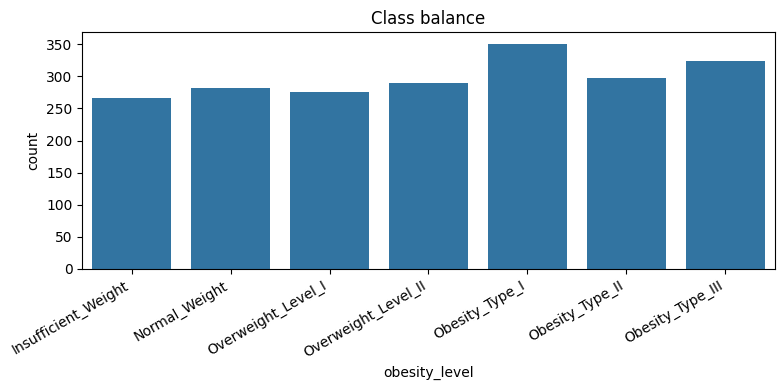

In [138]:
# Target (class balance) + define an ordered target

# Define the expected ordered classes and coerce the column
order = [
    "Insufficient_Weight", "Normal_Weight",
    "Overweight_Level_I", "Overweight_Level_II",
    "Obesity_Type_I", "Obesity_Type_II", "Obesity_Type_III"
]

# Trim whitespace
df["obesity_level"] = df["obesity_level"].str.strip()

# Sanity check
unexpected = sorted(set(df["obesity_level"].unique()) - set(order))
print("Unexpected labels:", unexpected)  # should be []

# Ordered categorical
df["obesity_level"] = pd.Categorical(df["obesity_level"], categories=order, ordered=True)

# Counts in ordinal order
cls = df["obesity_level"].value_counts(dropna=False).reindex(order).to_frame("count")
cls["pct"] = (cls["count"] / cls["count"].sum() * 100).round(2)
display(cls)

# Bar plot in ordinal order
plt.figure(figsize=(8,4))
sns.countplot(data=df, x="obesity_level", order=order)
plt.xticks(rotation=30, ha="right"); plt.title("Class balance"); plt.tight_layout(); plt.show()

Numeric columns: ['Age', 'Height', 'Weight', 'FCVC', 'NCP', 'CH2O', 'FAF', 'TUE']


,count,mean,std,min,25%,50%,75%,max
Age,2087.0,24.353090,6.368801,14.00,19.915937,22.847618,26.000000,61.00
Height,2087.0,1.702674,0.093186,1.45,1.630178,1.701584,1.769491,1.98
Weight,2087.0,86.858730,26.190847,39.00,66.000000,83.101100,108.015907,173.00
FCVC,2087.0,2.421466,0.534737,1.00,2.000000,2.396265,3.000000,3.00
NCP,2087.0,2.701179,0.764614,1.00,2.697467,3.000000,3.000000,4.00
CH2O,2087.0,2.004749,0.608284,1.00,1.590922,2.000000,2.466193,3.00
FAF,2087.0,1.012812,0.853475,0.00,0.124505,1.000000,1.678102,3.00
TUE,2087.0,0.663035,0.608153,0.00,0.000000,0.630866,1.000000,2.00


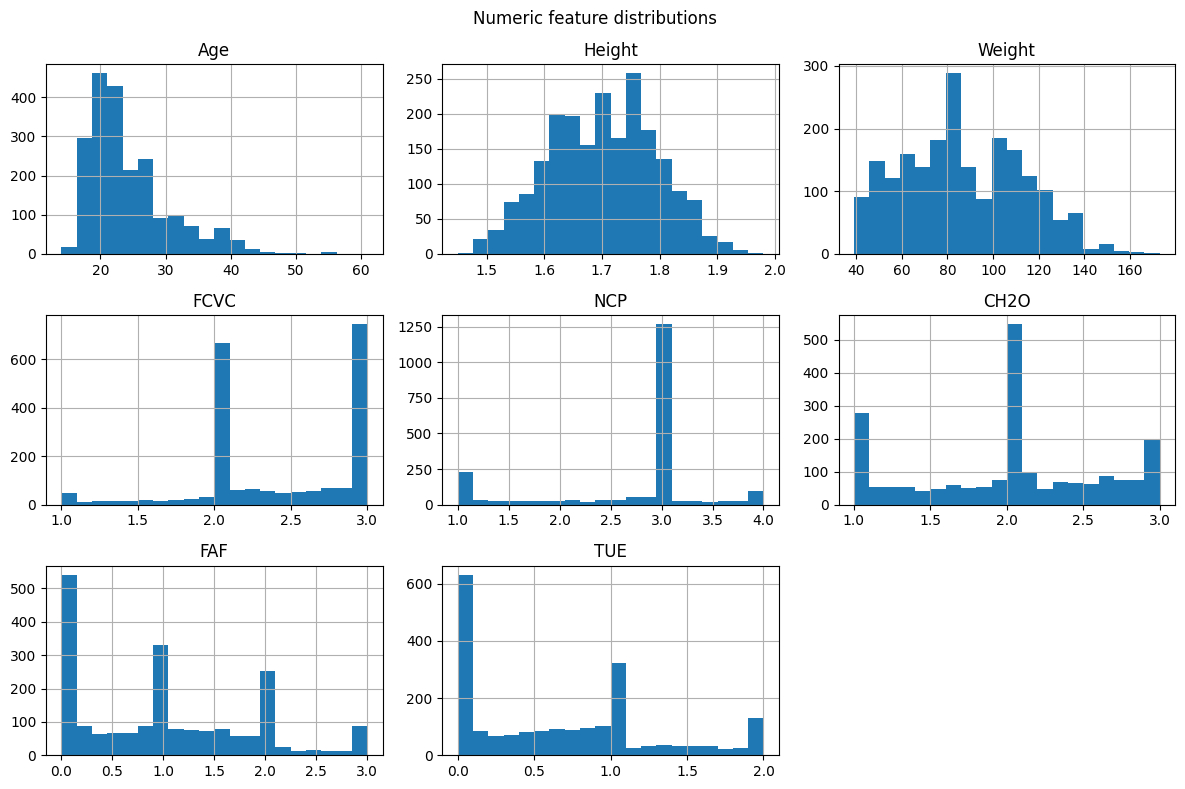

<Figure size 1200x400 with 0 Axes>

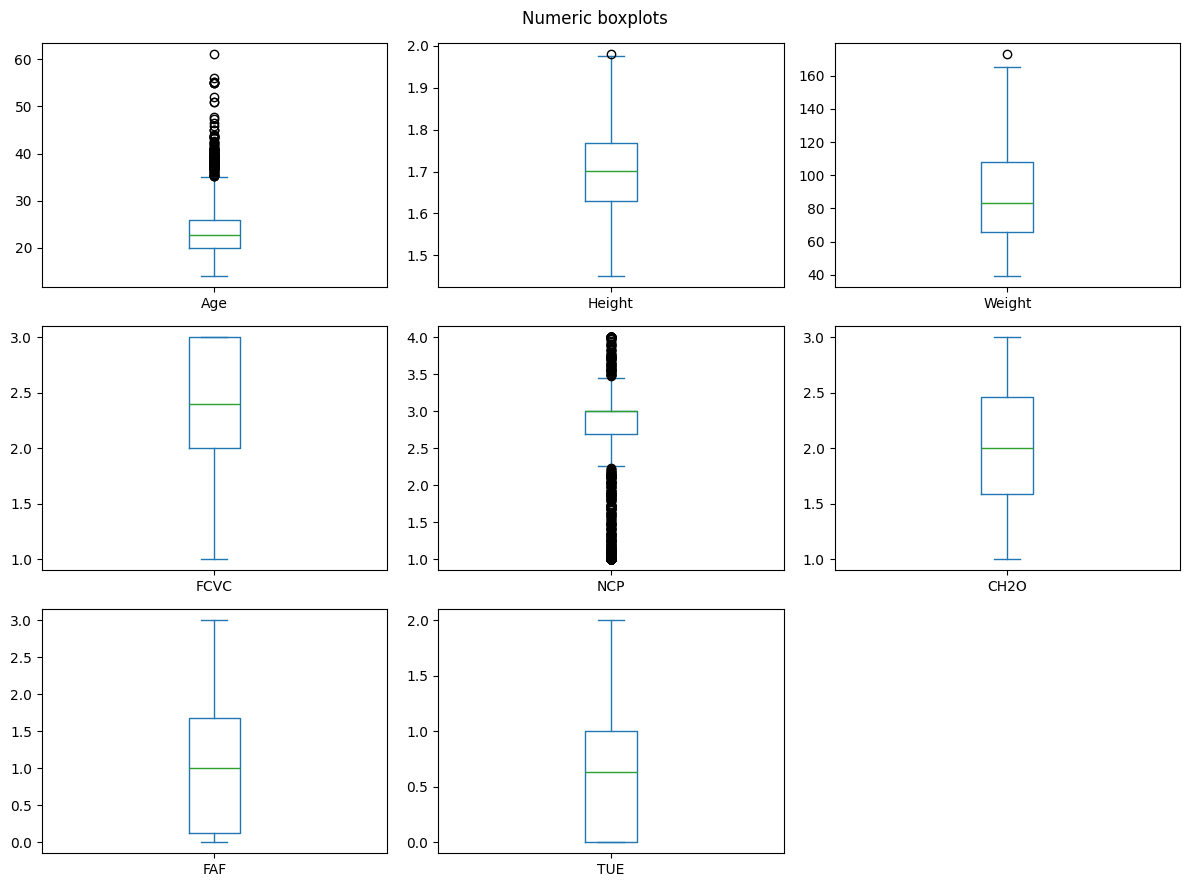

In [139]:
# Numeric features: distributions and outliers
num_cols = df.select_dtypes(include=np.number).columns.tolist()
print("Numeric columns:", num_cols)

if num_cols:
    display(df[num_cols].describe().T)

    # histograms
    df[num_cols].hist(figsize=(12,8), bins=20)
    plt.suptitle("Numeric feature distributions"); plt.tight_layout(); plt.show()

    # boxplots to eyeball outliers
    plt.figure(figsize=(12, max(3, 0.5*len(num_cols))))
    df[num_cols].plot(kind="box", subplots=True, layout=(-1,3), figsize=(12, 3*((len(num_cols)+2)//3)))
    plt.suptitle("Numeric boxplots"); plt.tight_layout(); plt.show()

Categorical columns: ['Gender', 'family_history_with_overweight', 'FAVC', 'CAEC', 'SMOKE', 'SCC', 'CALC', 'MTRANS']

Gender (nunique=2):


,count
Gender,
Male,1052
Female,1035



family_history_with_overweight (nunique=2):


,count
family_history_with_overweight,
yes,1722
no,365



FAVC (nunique=2):


,count
FAVC,
yes,1844
no,243



CAEC (nunique=4):


,count
CAEC,
Sometimes,1761
Frequently,236
Always,53
no,37



SMOKE (nunique=2):


,count
SMOKE,
no,2043
yes,44



SCC (nunique=2):


,count
SCC,
no,1991
yes,96



CALC (nunique=4):


,count
CALC,
Sometimes,1380
no,636
Frequently,70
Always,1



MTRANS (nunique=5):


,count
MTRANS,
Public_Transportation,1558
Automobile,456
Walking,55
Motorbike,11
Bike,7


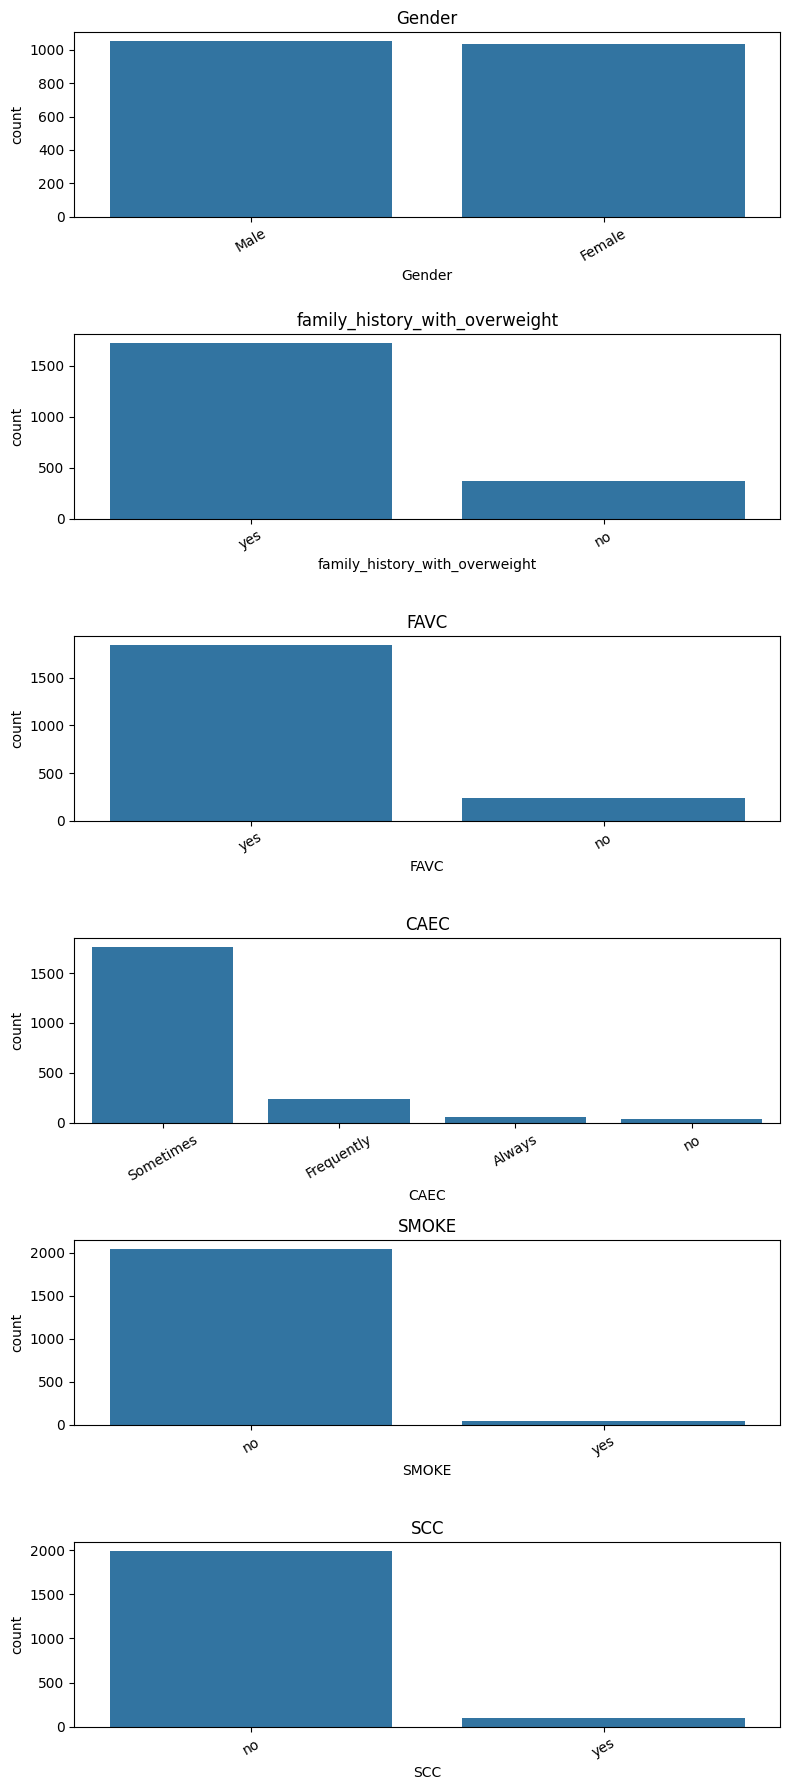

In [140]:
# Categorical features: levels & sanity checks

cat_cols = [c for c in df.columns if c not in num_cols + ["obesity_level"]]
print("Categorical columns:", cat_cols)

# top categories per column
for c in cat_cols[:10]:
    vc = df[c].value_counts(dropna=False)
    print(f"\n{c} (nunique={vc.shape[0]}):")
    display(vc.head(10))

# quick plots for a few key categoricals (edit list to taste)
key_cats = cat_cols[:6]  # change to specific names you care about
fig, axes = plt.subplots(len(key_cats), 1, figsize=(8, 3*len(key_cats)))
if len(key_cats)==1: axes=[axes]
for ax, c in zip(axes, key_cats):
    sns.countplot(data=df, x=c, ax=ax, order=df[c].value_counts().index)
    ax.set_title(c); ax.tick_params(axis='x', rotation=30)
plt.tight_layout(); plt.show()

/tmp/ipython-input-3901948861.py:6: FutureWarning: 

The `scale` parameter has been renamed and will be removed in v0.15.0. Pass `density_norm='width'` for the same effect.
  sns.violinplot(data=df, x="obesity_level", y=c, inner="quartile", scale="width")


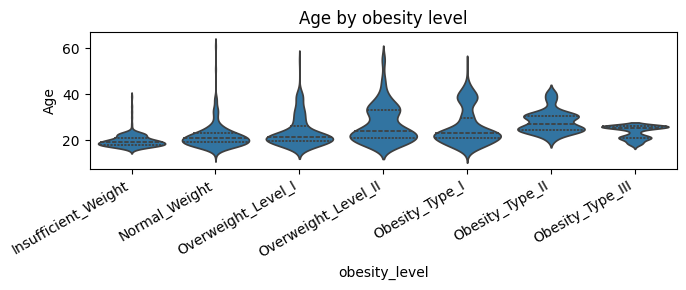

/tmp/ipython-input-3901948861.py:6: FutureWarning: 

The `scale` parameter has been renamed and will be removed in v0.15.0. Pass `density_norm='width'` for the same effect.
  sns.violinplot(data=df, x="obesity_level", y=c, inner="quartile", scale="width")


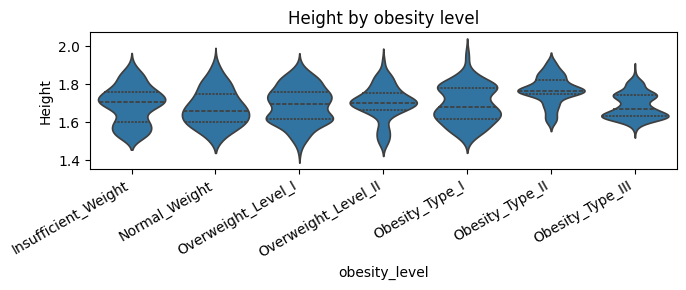

/tmp/ipython-input-3901948861.py:6: FutureWarning: 

The `scale` parameter has been renamed and will be removed in v0.15.0. Pass `density_norm='width'` for the same effect.
  sns.violinplot(data=df, x="obesity_level", y=c, inner="quartile", scale="width")


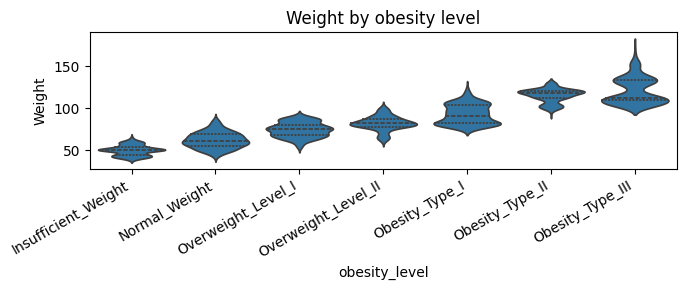

/tmp/ipython-input-3901948861.py:6: FutureWarning: 

The `scale` parameter has been renamed and will be removed in v0.15.0. Pass `density_norm='width'` for the same effect.
  sns.violinplot(data=df, x="obesity_level", y=c, inner="quartile", scale="width")


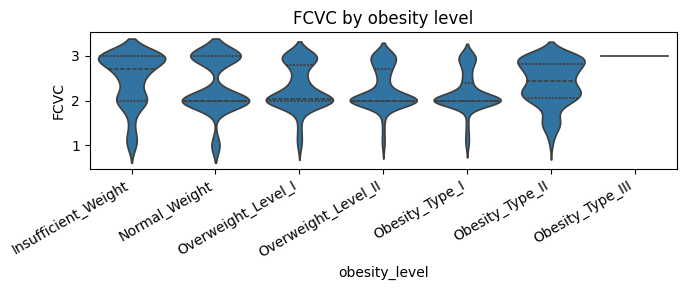

/tmp/ipython-input-3901948861.py:6: FutureWarning: 

The `scale` parameter has been renamed and will be removed in v0.15.0. Pass `density_norm='width'` for the same effect.
  sns.violinplot(data=df, x="obesity_level", y=c, inner="quartile", scale="width")


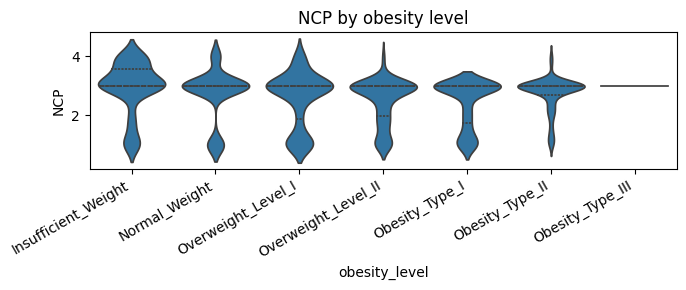

/tmp/ipython-input-3901948861.py:6: FutureWarning: 

The `scale` parameter has been renamed and will be removed in v0.15.0. Pass `density_norm='width'` for the same effect.
  sns.violinplot(data=df, x="obesity_level", y=c, inner="quartile", scale="width")


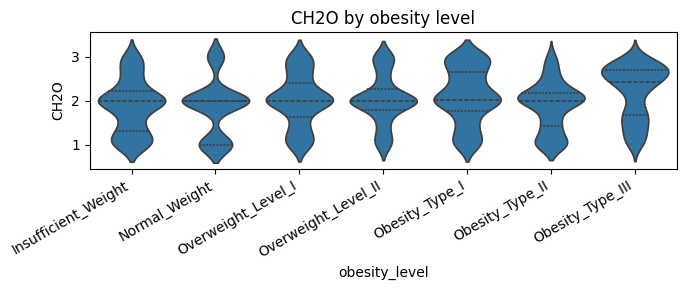

/tmp/ipython-input-3901948861.py:6: FutureWarning: 

The `scale` parameter has been renamed and will be removed in v0.15.0. Pass `density_norm='width'` for the same effect.
  sns.violinplot(data=df, x="obesity_level", y=c, inner="quartile", scale="width")


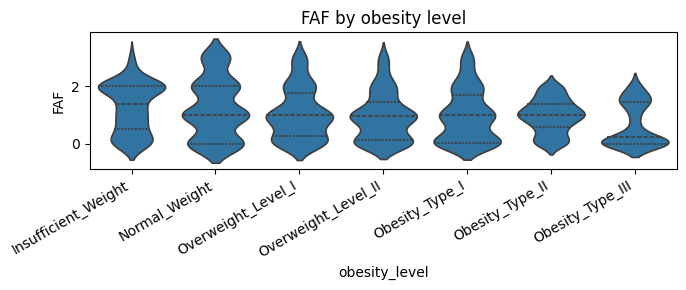

/tmp/ipython-input-3901948861.py:6: FutureWarning: 

The `scale` parameter has been renamed and will be removed in v0.15.0. Pass `density_norm='width'` for the same effect.
  sns.violinplot(data=df, x="obesity_level", y=c, inner="quartile", scale="width")


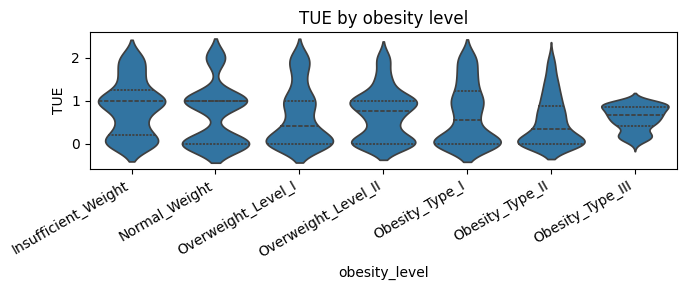

obesity_level,Insufficient_Weight,Normal_Weight,Overweight_Level_I,Overweight_Level_II,Obesity_Type_I,Obesity_Type_II,Obesity_Type_III
Gender,,,,,,,
Female,16.3,13.2,14.0,10.0,15.1,0.2,31.2
Male,9.3,13.8,12.5,17.8,18.5,28.0,0.1


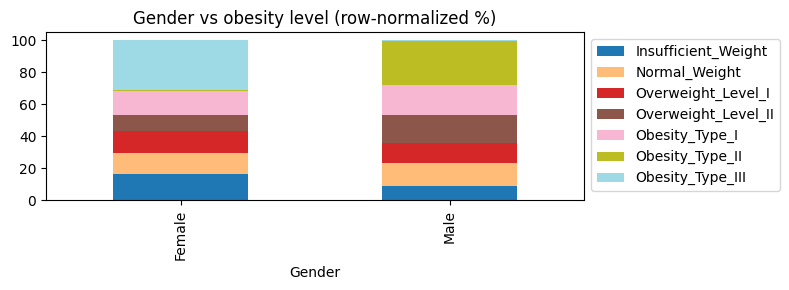

obesity_level,Insufficient_Weight,Normal_Weight,Overweight_Level_I,Overweight_Level_II,Obesity_Type_I,Obesity_Type_II,Obesity_Type_III
family_history_with_overweight,,,,,,,
no,38.9,35.6,18.4,4.9,1.9,0.3,0.0
yes,7.3,8.8,12.1,15.8,20.0,17.2,18.8


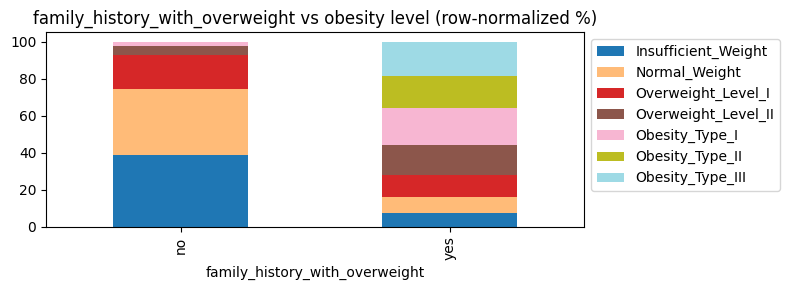

obesity_level,Insufficient_Weight,Normal_Weight,Overweight_Level_I,Overweight_Level_II,Obesity_Type_I,Obesity_Type_II,Obesity_Type_III
FAVC,,,,,,,
no,20.6,32.1,9.1,30.5,4.5,2.9,0.4
yes,11.8,11.1,13.8,11.7,18.4,15.7,17.5


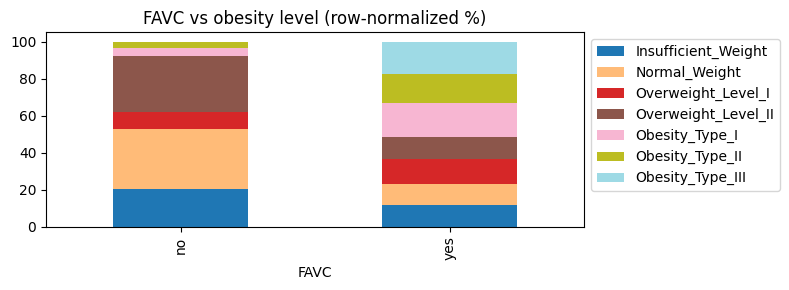

obesity_level,Insufficient_Weight,Normal_Weight,Overweight_Level_I,Overweight_Level_II,Obesity_Type_I,Obesity_Type_II,Obesity_Type_III
CAEC,,,,,,,
Always,3.8,66.0,9.4,5.7,11.3,3.8,0.0
Frequently,49.6,34.3,5.9,6.8,2.5,0.4,0.4
Sometimes,8.2,8.9,13.4,15.3,19.2,16.6,18.3
no,8.1,27.0,56.8,2.7,2.7,2.7,0.0


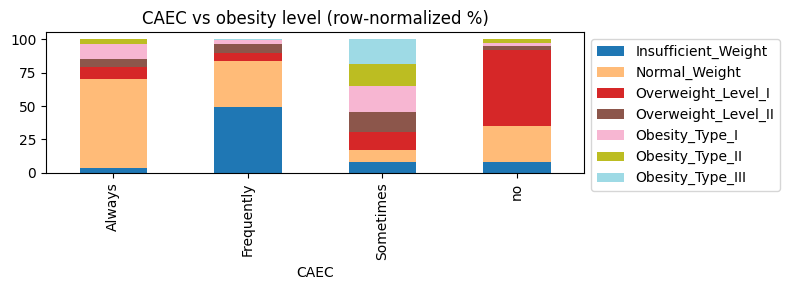

obesity_level,Insufficient_Weight,Normal_Weight,Overweight_Level_I,Overweight_Level_II,Obesity_Type_I,Obesity_Type_II,Obesity_Type_III
SMOKE,,,,,,,
no,13.0,13.2,13.4,14.0,16.9,13.8,15.8
yes,2.3,29.5,6.8,11.4,13.6,34.1,2.3


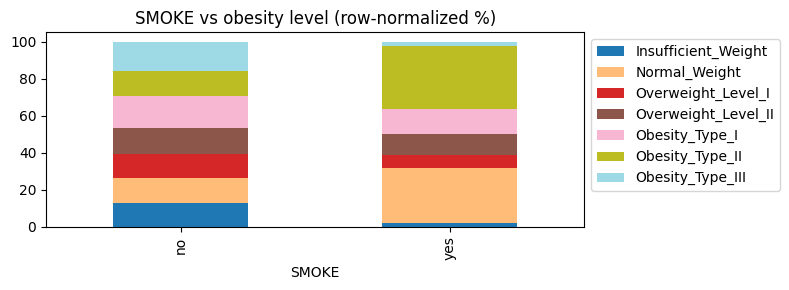

obesity_level,Insufficient_Weight,Normal_Weight,Overweight_Level_I,Overweight_Level_II,Obesity_Type_I,Obesity_Type_II,Obesity_Type_III
SCC,,,,,,,
no,12.3,12.7,12.0,14.4,17.5,14.9,16.3
yes,22.9,31.2,38.5,4.2,2.1,1.0,0.0


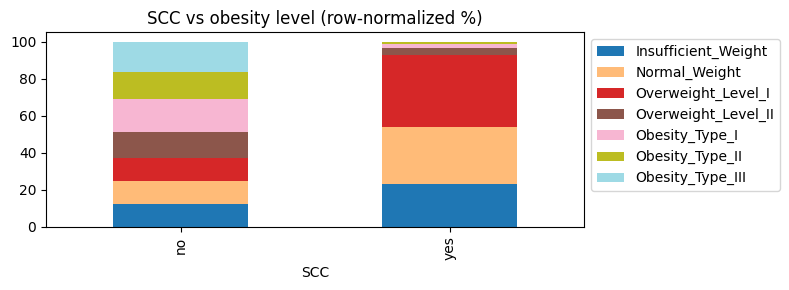

In [141]:
# Simple relationships with the target

# numeric vs target (violin/box)
for c in num_cols:
    plt.figure(figsize=(7,3))
    sns.violinplot(data=df, x="obesity_level", y=c, inner="quartile", scale="width")
    plt.xticks(rotation=30, ha="right"); plt.title(f"{c} by obesity level")
    plt.tight_layout(); plt.show()

# categorical vs target: normalized stacked bars (top 5 categories per feature)
for c in cat_cols[:6]:
    ct = (pd.crosstab(df[c], df["obesity_level"], normalize="index")*100).round(1)
    display(ct.head(10))
    ct.plot(kind="bar", stacked=True, figsize=(8,3), colormap="tab20")
    plt.title(f"{c} vs obesity level (row-normalized %)"); plt.legend(bbox_to_anchor=(1,1)); plt.tight_layout(); plt.show()

In [142]:
# Basic cleaning
# strip whitespace from string categories
for c in cat_cols + ["obesity_level"]:
    if pd.api.types.is_string_dtype(df[c]):
        df[c] = df[c].str.strip()

# standardize common yes/no style fields if present
yn_map = {"yes":"yes","y":"yes","no":"no","n":"no","Yes":"yes","No":"no"}
for c in cat_cols:
    if set(df[c].dropna().unique()).issubset(set(yn_map.keys()) | set(df[c].dropna().unique())):
        df[c] = df[c].replace(yn_map)

# sanity bounds on numeric columns (example: nonnegative)
for c in num_cols:
    if (df[c] < 0).any():
        print(f"Clipping negatives in {c}")
        df[c] = df[c].clip(lower=0)

In [143]:
#Splitting and preprocessing

from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import f1_score, balanced_accuracy_score, confusion_matrix, classification_report
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.feature_selection import VarianceThreshold

target = "obesity_level"

X = df.drop(columns=[target])
y = pd.Series(
    pd.Categorical(df[target].str.strip(), categories=order, ordered=True),
    name=target
)

num_cols = X.select_dtypes(include=np.number).columns.tolist()
cat_cols = [c for c in X.columns if c not in num_cols]

X_train, X_test, y_train_cat, y_test_cat = train_test_split(
    X, y, test_size=0.20, stratify=y, random_state=42
)

# integer labels for metrics
y_train_codes = y_train_cat.cat.codes.to_numpy()
y_test_codes  = y_test_cat.cat.codes.to_numpy()
class_names   = list(y_train_cat.cat.categories)

# preprocessors
# robust encoder for the ordinal model (prevents constant all-ones dummies)
ohe_ord = OneHotEncoder(
    handle_unknown="ignore",
    drop="first",
    sparse_output=False,
    min_frequency=10
)

pre_ordinal = Pipeline(steps=[
    ("ct", ColumnTransformer(
        transformers=[
            ("num", StandardScaler(), num_cols),
            ("cat", ohe_ord, cat_cols),
        ],
        remainder="drop",
    )),
    ("vt", VarianceThreshold(threshold=0.0)),      # strips any remaining constant cols
])

pre_tree = ColumnTransformer(
    transformers=[
        ("num", "passthrough", num_cols),
        ("cat", OneHotEncoder(drop="first", handle_unknown="ignore",
                              sparse_output=False), cat_cols),
    ],
    remainder="drop",
)

Xtr_ord = pre_ordinal.fit_transform(X_train)
Xte_ord = pre_ordinal.transform(X_test)

Xtr_tree = pre_tree.fit_transform(X_train)
Xte_tree = pre_tree.transform(X_test)

In [144]:
# Ordinal logistics regression model

from statsmodels.miscmodels.ordinal_model import OrderedModel
from sklearn.metrics import f1_score, balanced_accuracy_score

def fit_ordinal_dropconst(X_tr, y_tr, eps=1e-12):
    X_tr = np.asarray(X_tr, dtype=float)
    keep = np.ptp(X_tr, axis=0) > eps
    X_use = X_tr[:, keep]
    mdl = OrderedModel(endog=y_tr, exog=X_use, distr="logit")
    res = mdl.fit(method="lbfgs", maxiter=1000, disp=False)
    return mdl, res, keep

def predict_codes_ord(res, X_arr, keep_mask):
    X_use = np.asarray(X_arr, dtype=float)[:, keep_mask]
    probs = res.model.predict(res.params, exog=X_use)
    return np.asarray(probs).argmax(axis=1)

# CV on the ordinal model
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
f1s, bals = [], []

for tr_idx, va_idx in cv.split(Xtr_ord, y_train_codes):
    mdl, res, keep = fit_ordinal_dropconst(Xtr_ord[tr_idx], y_train_codes[tr_idx])
    pred = predict_codes_ord(res, Xtr_ord[va_idx], keep)
    f1s.append(f1_score(y_train_codes[va_idx], pred, average="macro"))
    bals.append(balanced_accuracy_score(y_train_codes[va_idx], pred))

print(f"Ordinal Logit (CV)  Macro-F1: {np.mean(f1s):.3f}  Balanced Acc: {np.mean(bals):.3f}")

# ---- fit on full training set, evaluate on held-out test ----
mdl_full, res_full, keep_full = fit_ordinal_dropconst(Xtr_ord, y_train_codes)
test_pred = predict_codes_ord(res_full, Xte_ord, keep_full)
print("Ordinal Logit (Test) Macro-F1: {:.3f}  Balanced Acc: {:.3f}"
      .format(f1_score(y_test_codes, test_pred, average="macro"),
              balanced_accuracy_score(y_test_codes, test_pred)))


Ordinal Logit (CV)  Macro-F1: 0.909  Balanced Acc: 0.910
Ordinal Logit (Test) Macro-F1: 0.907  Balanced Acc: 0.907


In [145]:
# Ordinal Logistic final fit
mdl_full, res_full, keep_full = fit_ordinal_dropconst(Xtr_ord, y_train_codes)
pred_test_ord = predict_codes_ord(res_full, Xte_ord, keep_full)

print("Ordinal Logistic — Test")
print("  Macro-F1:        {:.3f}".format(f1_score(y_test_codes, pred_test_ord, average="macro")))
print("  Balanced Acc:    {:.3f}".format(balanced_accuracy_score(y_test_codes, pred_test_ord)))
print("\nClassification report (Ordinal):")
print(classification_report(y_test_codes, pred_test_ord, target_names=class_names, digits=3))

# confusion matrix
cm_ord = confusion_matrix(y_test_codes, pred_test_ord)
cm_ord

Ordinal Logistic — Test
  Macro-F1:        0.907
  Balanced Acc:    0.907

Classification report (Ordinal):
                     precision    recall  f1-score   support

Insufficient_Weight      0.891     0.925     0.907        53
      Normal_Weight      0.907     0.860     0.883        57
 Overweight_Level_I      0.923     0.873     0.897        55
Overweight_Level_II      0.902     0.948     0.924        58
     Obesity_Type_I      0.972     0.986     0.979        70
    Obesity_Type_II      0.844     0.900     0.871        60
   Obesity_Type_III      0.918     0.862     0.889        65

           accuracy                          0.909       418
          macro avg      0.908     0.907     0.907       418
       weighted avg      0.910     0.909     0.909       418



array([[49,  4,  0,  0,  0,  0,  0],
       [ 6, 49,  2,  0,  0,  0,  0],
       [ 0,  1, 48,  6,  0,  0,  0],
       [ 0,  0,  2, 55,  1,  0,  0],
       [ 0,  0,  0,  0, 69,  1,  0],
       [ 0,  0,  0,  0,  1, 54,  5],
       [ 0,  0,  0,  0,  0,  9, 56]])

In [146]:
# 5-fold CV loop for the Gradient-Boosted Trees baseline

from sklearn.ensemble import HistGradientBoostingClassifier

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

f1s, bals = [], []

for tr_idx, va_idx in cv.split(Xtr_tree, y_train_codes):
    X_tr, X_va = Xtr_tree[tr_idx], Xtr_tree[va_idx]
    y_tr, y_va = y_train_codes[tr_idx], y_train_codes[va_idx]

    gb = HistGradientBoostingClassifier(
        loss="log_loss",         # multiclass
        learning_rate=0.08,
        max_iter=400,
        max_depth=None,
        random_state=42
    )
    gb.fit(X_tr, y_tr)
    pred = gb.predict(X_va)

    f1s.append(f1_score(y_va, pred, average="macro"))
    bals.append(balanced_accuracy_score(y_va, pred))

print("GBDT (5-fold CV)  Macro-F1: {:.3f}  Balanced Acc: {:.3f}"
      .format(np.mean(f1s), np.mean(bals)))

GBDT (5-fold CV)  Macro-F1: 0.964  Balanced Acc: 0.964


In [147]:
# Run final fit and test

# train on all training rows
gb = HistGradientBoostingClassifier(
    loss="log_loss",
    learning_rate=0.08,
    max_iter=400,
    max_depth=None,
    random_state=42
)
gb.fit(Xtr_tree, y_train_codes)

# evaluate on the held-out test set
pred_test_gb = gb.predict(Xte_tree)

print("GBDT — Test")
print("  Macro-F1:     {:.3f}".format(f1_score(y_test_codes, pred_test_gb, average="macro")))
print("  Balanced Acc: {:.3f}".format(balanced_accuracy_score(y_test_codes, pred_test_gb)))
print("\nClassification report (GBDT):")
print(classification_report(y_test_codes, pred_test_gb, target_names=class_names, digits=3))

cm_gb = confusion_matrix(y_test_codes, pred_test_gb)
cm_gb

GBDT — Test
  Macro-F1:     0.973
  Balanced Acc: 0.973

Classification report (GBDT):
                     precision    recall  f1-score   support

Insufficient_Weight      0.981     1.000     0.991        53
      Normal_Weight      0.964     0.947     0.956        57
 Overweight_Level_I      0.943     0.909     0.926        55
Overweight_Level_II      0.935     1.000     0.967        58
     Obesity_Type_I      1.000     0.971     0.986        70
    Obesity_Type_II      0.984     1.000     0.992        60
   Obesity_Type_III      1.000     0.985     0.992        65

           accuracy                          0.974       418
          macro avg      0.973     0.973     0.973       418
       weighted avg      0.974     0.974     0.974       418



array([[53,  0,  0,  0,  0,  0,  0],
       [ 1, 54,  2,  0,  0,  0,  0],
       [ 0,  2, 50,  3,  0,  0,  0],
       [ 0,  0,  0, 58,  0,  0,  0],
       [ 0,  0,  1,  1, 68,  0,  0],
       [ 0,  0,  0,  0,  0, 60,  0],
       [ 0,  0,  0,  0,  0,  1, 64]])

In [148]:
# Put results of both models side by side
res = pd.DataFrame([
    {"model":"Ordinal Logit",
     "macro_f1_test": f1_score(y_test_codes, pred_test_ord, average="macro"),
     "bal_acc_test":  balanced_accuracy_score(y_test_codes, pred_test_ord)},
    {"model":"HistGradientBoosting",
     "macro_f1_test": f1_score(y_test_codes, pred_test_gb,  average="macro"),
     "bal_acc_test":  balanced_accuracy_score(y_test_codes, pred_test_gb)}
]).round(3)
res

,model,macro_f1_test,bal_acc_test
0,Ordinal Logit,0.907,0.907
1,HistGradientBoosting,0.973,0.973


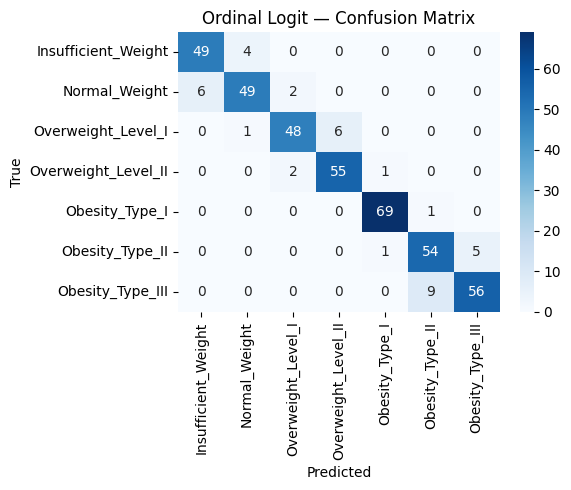

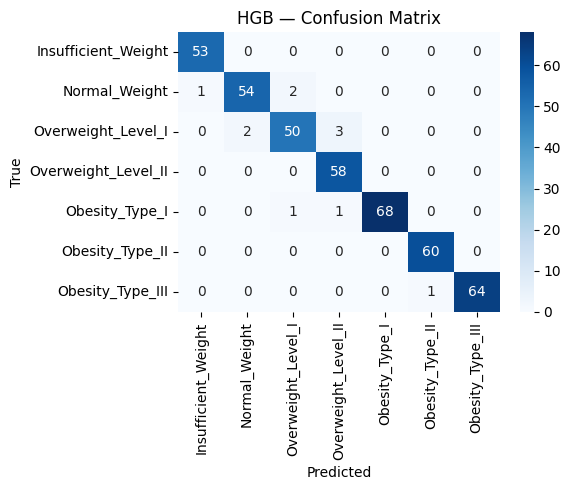

In [149]:
# Visual errors of confusion matrices
def plot_cm(y_true, y_pred, labels, title):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6,5))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                xticklabels=labels, yticklabels=labels)
    plt.xlabel("Predicted"); plt.ylabel("True"); plt.title(title)
    plt.tight_layout(); plt.show()

plot_cm(y_test_codes, pred_test_ord, class_names, "Ordinal Logit — Confusion Matrix")
plot_cm(y_test_codes, pred_test_gb,  class_names, "HGB — Confusion Matrix")

In [150]:
#Ordinal-friendly error check
def ordinal_error_breakdown(y_true_codes, y_pred_codes):
    diff = np.abs(y_true_codes - y_pred_codes)
    return {
        "acc":     (diff==0).mean(),
        "off_by_1":(diff==1).mean(),
        "off_by_2+":(diff>=2).mean()
    }

print("Ordinal Logit:", ordinal_error_breakdown(y_test_codes, pred_test_ord))
print("HGB:",          ordinal_error_breakdown(y_test_codes, pred_test_gb))

Ordinal Logit: {'acc': np.float64(0.9090909090909091), 'off_by_1': np.float64(0.09090909090909091), 'off_by_2+': np.float64(0.0)}
HGB: {'acc': np.float64(0.9736842105263158), 'off_by_1': np.float64(0.023923444976076555), 'off_by_2+': np.float64(0.0023923444976076554)}
